# Automated Sensing of Red vs. White Wine
_... with the cheapest sensor possible_

#### Data Science 420 BB
#### University of Washington Professional & Continuing Education

#### Homework 2: Low-cost Sensor, Desigion Trees
#### Leo Salemann, 4/25/18

# OBJECTIVES

1. Design a simple, low-cost sensor that can distinguish between red wine and white wine for at least 95%
of the samples. In other words, achive 95% accuracy with the minimum number of features.
1. Assess Accuracy when using all sensors
1. Find the ninimum number of sensors that still maintains 90% accuracy or better.

# LOAD DATA

In [1]:
file <- "./RedWhiteWine.csv"
data <- read.csv(file, header=TRUE, sep=",", stringsAsFactors = FALSE)

# If the target column, say column class, is numerical, you need to convert it to factors in R for classification problem
data$Class <- factor(data$Class)
head(data)
dim(data)


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,Class
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,1
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,1
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,1
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,1


[1] 6497   13

In [2]:
install.packages("dplyr")
library(dplyr)

Installing package into ‘/home/vagrant/R/x86_64-pc-linux-gnu-library/3.2’
(as ‘lib’ is unspecified)



The downloaded source packages are in
	‘/tmp/RtmpIQGNob/downloaded_packages’



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Make a function that quickly tests Decision Tree accuracy

Very similar to the function we had in HW 1, just replacing the nbc part with a decision tree.

In [3]:
# Classification Tree with rpart
install.packages("rpart")
library(rpart)

Installing package into ‘/home/vagrant/R/x86_64-pc-linux-gnu-library/3.2’
(as ‘lib’ is unspecified)



The downloaded source packages are in
	‘/tmp/RtmpIQGNob/downloaded_packages’


In [4]:
options(repr.plot.width=12, repr.plot.height=12)

test_tree_accuracy <- function(df, plot=FALSE) {
 
    # df = select(df, -Color)
    # split into test and training sets
    nrows <- nrow(df)
    smp_size <- floor(0.75 * nrows)

    set.seed(42)
    train_ind <- sample(seq_len(nrows), size = smp_size)
    
    train <- df[train_ind, ]
    test <- df[-train_ind, ]
    
    formula <- as.formula('Class ~ .')

    # grow tree 
    tree_model <- rpart(formula,
                 method="class", data=train, control=rpart.control(minsplit=30, cp=0.01))
    
    if (plot) {
        # plot tree 
        plot(tree_model, uniform=TRUE, 
             main="Classification Tree for Red(1) vs. White(0) Wine")
        text(tree_model, use.n=TRUE, all=TRUE, cex=.8)
    }
    
    # Make a prediction & test accuracy
    test_pred <- predict(tree_model, test, type = "class")
    
    ### junky debug stuff
    # print(head (test_pred))
    ### junky debug stuff
    accuracy <- sum(test[,"Class"]==test_pred)/length(test_pred)
    print("-----------------------< Features Used >----------------------------------")
    print(colnames(df))
    print(paste("Accuracy=", round(accuracy*100,2), "%", sep=""))
    print("------------------------------------")
    print(paste(''))
}

# Accuracy With All Attributes

In [5]:
test_tree_accuracy(data)

[1] "-----------------------< Features Used >----------------------------------"
 [1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "quality"             
[13] "Class"               
[1] "Accuracy=97.72%"
[1] "------------------------------------"
[1] ""


Okay, 97.72% accuracy (NBC was 97.91%). Not bad.  Let's start keeping score.

| Configuration | Tree Accuracy | NBC Acuracy |
|---------------|---------------|-------------|
|All features   | 97.72%        |  97.91%     |

# Accuracy With Minimal Subset and 95% Threshold

Utilize the Decision tree to avoide brute-force approaches. 

Trying a few tricks recommended by the [Tree-Based Models article](https://www.statmethods.net/advstats/cart.html) from [Quick-R](https://www.statmethods.net/index.html)

In [6]:
fit <- rpart (Class ~ ., method="class", data=data)

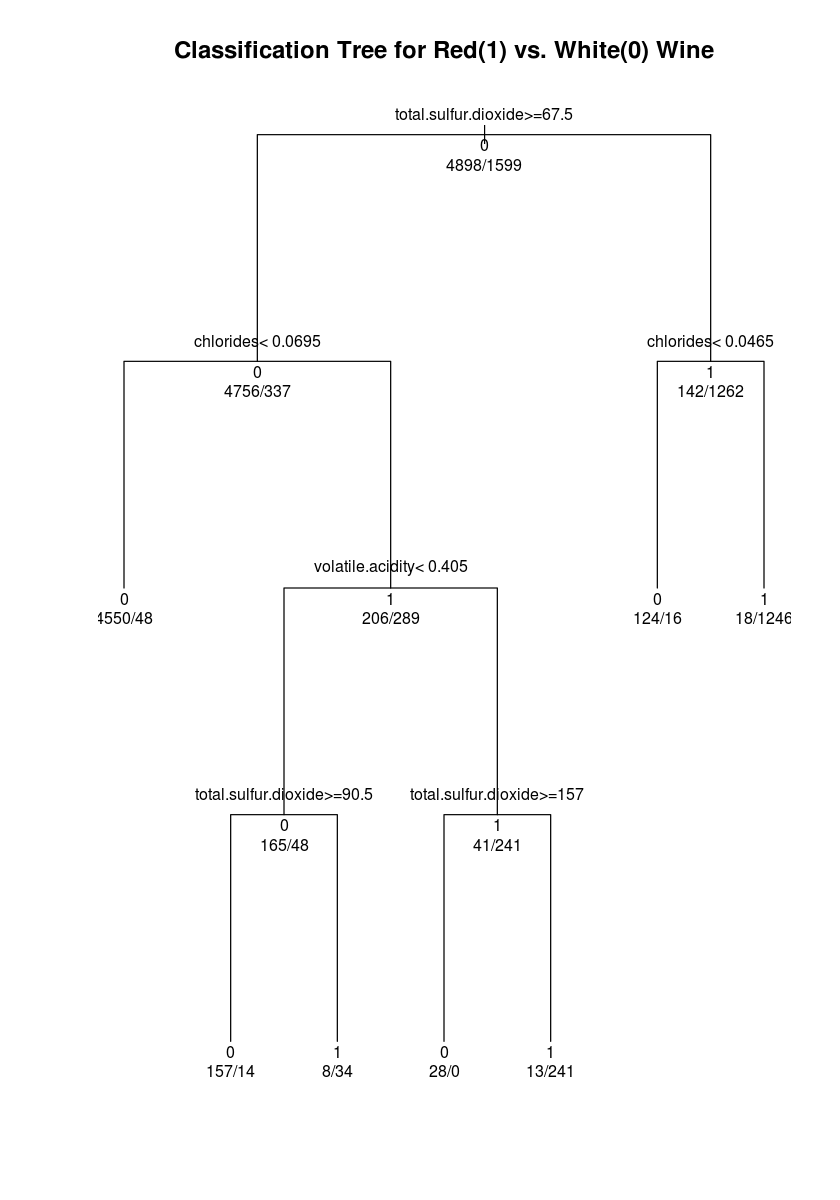

In [7]:
options(repr.plot.width=7, repr.plot.height=10)
# plot tree 
 plot(fit, uniform=TRUE, 
    main="Classification Tree for Red(1) vs. White(0) Wine")
 text(fit, use.n=TRUE, all=TRUE, cex=.8)

Starting at the top of the tree and traversing down, it looks like our best shot at 95% accruacy is to detect **total.sulfur.dioxide**, then add **chlorides** then add **volatile.acidity** Plot the cross-validation results to make sure.

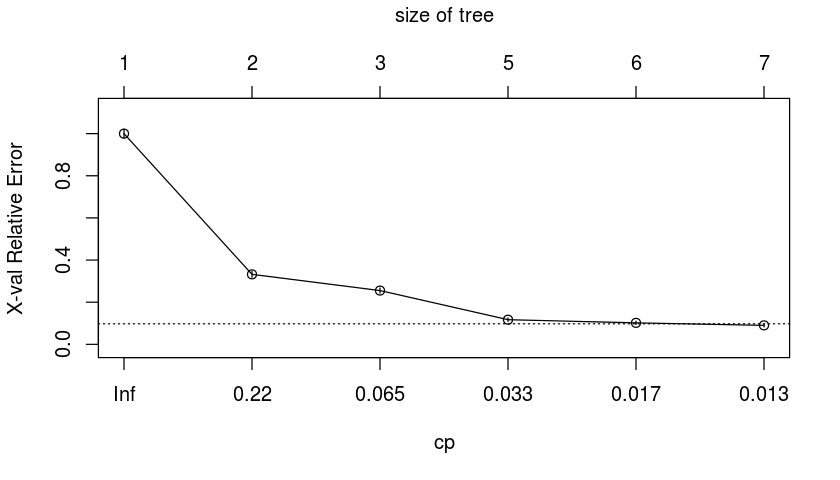

In [8]:
options(repr.plot.width=7, repr.plot.height=4)
plotcp(fit)

Yup, relative error decreases monotonically as you increase the size of the tree, though the law of diminishing returns kicks in pretty hard beyod 5 nodes.  Time to run those accuracy tests.

In [9]:
test_tree_accuracy(select(data, total.sulfur.dioxide, Class))
test_tree_accuracy(select(data, total.sulfur.dioxide, chlorides, Class))
test_tree_accuracy(select(data, total.sulfur.dioxide, chlorides, volatile.acidity, Class))

[1] "-----------------------< Features Used >----------------------------------"
[1] "total.sulfur.dioxide" "Class"               
[1] "Accuracy=93.05%"
[1] "------------------------------------"
[1] ""
[1] "-----------------------< Features Used >----------------------------------"
[1] "total.sulfur.dioxide" "chlorides"            "Class"               
[1] "Accuracy=96.86%"
[1] "------------------------------------"
[1] ""
[1] "-----------------------< Features Used >----------------------------------"
[1] "total.sulfur.dioxide" "chlorides"            "volatile.acidity"    
[4] "Class"               
[1] "Accuracy=97.29%"
[1] "------------------------------------"
[1] ""


Turns out **total.sulfur.dioxide** isn't enough on its own but adding **chlorides** is.  Update our leaderboard

**We can hit our thrshold with two features -- Sulfur Dioxide and Chorides**

| Configuration                        | Tree Accuracy | NBC Acuracy |
|--------------------------------------|---------------|-------------|
|All features                          | 97.72%        | 97.91%      |
|1 feature (sulfur.dioxide)            | 93.05%        | 93.11%      |
|2 features (sulfur.dioxide, chloride) | 96.86% | n/a |

# Visualizaing the Decision Tree

We've already visualized the full decison tree abive, let's try one with only our two attributes of interest.

In [10]:
options(repr.plot.width=8, repr.plot.height=9)

[1] "-----------------------< Features Used >----------------------------------"
[1] "Class"                "total.sulfur.dioxide" "chlorides"           
[1] "Accuracy=96.86%"
[1] "------------------------------------"
[1] ""


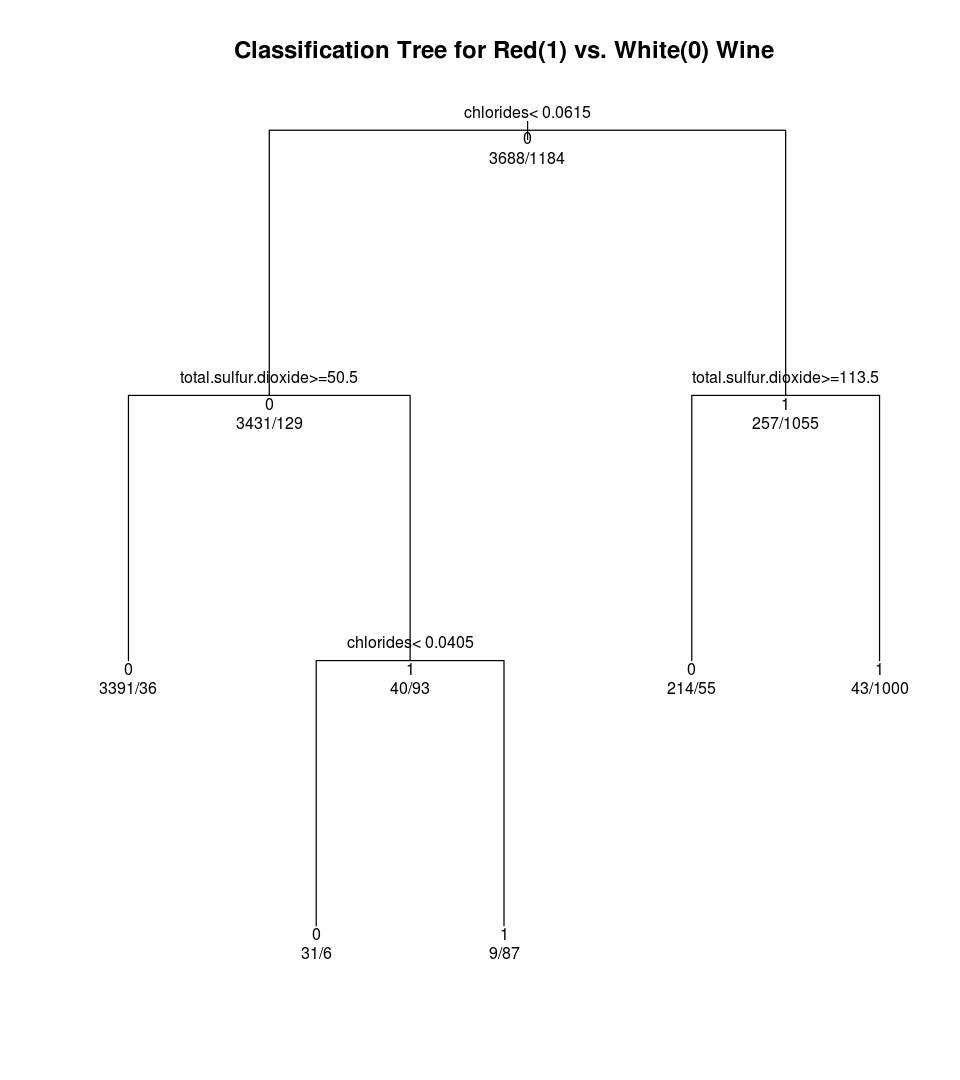

In [11]:
test_tree_accuracy(select(data, one_of(c('Class','total.sulfur.dioxide', 'chlorides'))), plot=TRUE)

Interesting that the original tree started with **total.sulfur.dioxide** at the top, but this one starts with **chlorides.**

# Finding the Minimum Number of Attributes

Our analysis so far suggests the minum number is two, but in the spirt of leaving no stone unturned, we'll try all the single-attribute possiblities.

In [12]:
test_tree_accuracy(select(data, fixed.acidity, Class))
test_tree_accuracy(select(data, volatile.acidity, Class))
test_tree_accuracy(select(data, citric.acid, Class))
test_tree_accuracy(select(data, residual.sugar, Class))
test_tree_accuracy(select(data, chlorides, Class))
test_tree_accuracy(select(data, free.sulfur.dioxide, Class))
test_tree_accuracy(select(data, total.sulfur.dioxide, Class))
test_tree_accuracy(select(data, density, Class))
test_tree_accuracy(select(data, pH, Class))
test_tree_accuracy(select(data, sulphates, Class))
test_tree_accuracy(select(data, alcohol, Class))

[1] "-----------------------< Features Used >----------------------------------"
[1] "fixed.acidity" "Class"        
[1] "Accuracy=80.92%"
[1] "------------------------------------"
[1] ""
[1] "-----------------------< Features Used >----------------------------------"
[1] "volatile.acidity" "Class"           
[1] "Accuracy=86.22%"
[1] "------------------------------------"
[1] ""
[1] "-----------------------< Features Used >----------------------------------"
[1] "citric.acid" "Class"      
[1] "Accuracy=80.25%"
[1] "------------------------------------"
[1] ""
[1] "-----------------------< Features Used >----------------------------------"
[1] "residual.sugar" "Class"         
[1] "Accuracy=83.57%"
[1] "------------------------------------"
[1] ""
[1] "-----------------------< Features Used >----------------------------------"
[1] "chlorides" "Class"    
[1] "Accuracy=91.94%"
[1] "------------------------------------"
[1] ""
[1] "-----------------------< Features Used >--------------

Sure enough, none of the single-attribute choices meet the 95% threshold, though a few do better than 90%


# Comparing to Naive Bayesian Classifier

Taking the leaderboard from  HW1 and comparing to what we have so far ...

|Features| Configuration                                   |NBC <br> Accuracy| Tree <br> Accuracy |
|--------|:------------------------------------------------|:------:|:------:|
| 12     |All features                                     | 97.91% | 97.72% |
| 1      |sulfur.dioxide                                   | 93.11% | 93.05% |
| 10     |All but pH and citric.acid                       | 97.41% |   n/a  |
| 4      |total.sulfur.dioxide, sulphates, alcohol, quality| 95.02% |   n/a  |
| 3      |total.sulfur.dioxide, sulphates, alcohol         | 94.89% |   n/a  |
| 2      |total.sulfur.dioxide, sulphates                  | 94.71% |   n/a  |
| 2      |total.sulfur.dioxide, chloride                   |   n/a  | 96.86% |

Running a few more tests to flesh out the leaderboard ..

In [13]:
test_tree_accuracy(select(data, -one_of(c('pH','citric.acid'))))
test_tree_accuracy(select(data, one_of(c('total.sulfur.dioxide', 'sulphates', 'alcohol', 'quality', 'Class'))))
test_tree_accuracy(select(data, one_of(c('total.sulfur.dioxide', 'sulphates', 'alcohol', 'Class' ))))
test_tree_accuracy(select(data, one_of(c('total.sulfur.dioxide', 'sulphates', 'Class' ))))


[1] "-----------------------< Features Used >----------------------------------"
 [1] "fixed.acidity"        "volatile.acidity"     "residual.sugar"      
 [4] "chlorides"            "free.sulfur.dioxide"  "total.sulfur.dioxide"
 [7] "density"              "sulphates"            "alcohol"             
[10] "quality"              "Class"               
[1] "Accuracy=97.72%"
[1] "------------------------------------"
[1] ""
[1] "-----------------------< Features Used >----------------------------------"
[1] "total.sulfur.dioxide" "sulphates"            "alcohol"             
[4] "quality"              "Class"               
[1] "Accuracy=95.26%"
[1] "------------------------------------"
[1] ""
[1] "-----------------------< Features Used >----------------------------------"
[1] "total.sulfur.dioxide" "sulphates"            "alcohol"             
[4] "Class"               
[1] "Accuracy=95.26%"
[1] "------------------------------------"
[1] ""
[1] "-----------------------< Features Used >

|Features| Configuration                                    |NBC <br> Accuracy| Tree <br> Accuracy |
|--------|:-------------------------------------------------|:------:|:------:|
| 12     |All features                                      | 97.91% | 97.72% |
| 1      |sulfur.dioxide                                    | 93.11% | 93.05% |
| 10     |All but pH and citric.acid                        | 97.41% | 97.72% |
| 4      |total.sulfur.dioxide, sulphates, alcohol, quality | 95.02% | 95.26% |
| 3      |total.sulfur.dioxide, sulphates, alcohol          | 94.89% | 95.26% |
| 2      |total.sulfur.dioxide, sulphates                   | 94.71% | 93.60% |
| 2      |total.sulfur.dioxide, chloride                    | 93.11% | 96.86% |

Performance of the two models is very similar, but it's interesting to see how they "flirt" with a 95% threshold. If you allow for rounding to a "whole" percentage, NBC predicts your best two-sensor model would detect **total sulfur dioxide** + **sulphates**, while the Decision Tree predicts **total sulfur dioxide** + **chloride**.  Applying a strict 95.00% rule, NBC suggests you need four attributes to meet threshold, while Decision Tree suggests you only need two.